In [1]:
# ## note these to add w/Poetry to the Dockerfile
# %pip install pandas
# %pip install networkx
# %pip install scipy

In [2]:
import os 
import tensorflow as tf
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.spatial.distance import pdist
from tensorflow.keras.layers import Dense, Multiply, Add
from tensorflow.keras import Model
from tensorflow.keras.constraints import NonNeg 
from tensorflow.python.ops.numpy_ops import np_config
os.chdir('..')
from src.data_cleaning import *
from src.mds_model import *
np_config.enable_numpy_behavior()


In [3]:
url = 'http://cs.bc.edu/~prudhome/AAPLD/animal-similarity.csv'

raw_dataset = pd.read_csv(url, index_col=0)
list_of_animal_pairs = raw_dataset.index.str.split('~')

In [4]:
animal_pair_data = pd.DataFrame.from_records(list_of_animal_pairs, columns=['first_animal', 'second_animal'], index= raw_dataset.index)

In [5]:
animal_pair_data.sort_values(by = ['first_animal', 'second_animal'], inplace=True)

In [6]:
unique_animals = set(animal_pair_data.first_animal).union(animal_pair_data.second_animal)

In [7]:
animal_pairs = nx.Graph()
animal_pairs.add_nodes_from(unique_animals)
animal_pairs.add_edges_from(list_of_animal_pairs)

In [8]:
low_degree=[k for k,v in animal_pairs.degree._nodes.items() if len(v) < 32]

In [9]:
animal_pairs.remove_nodes_from(low_degree)

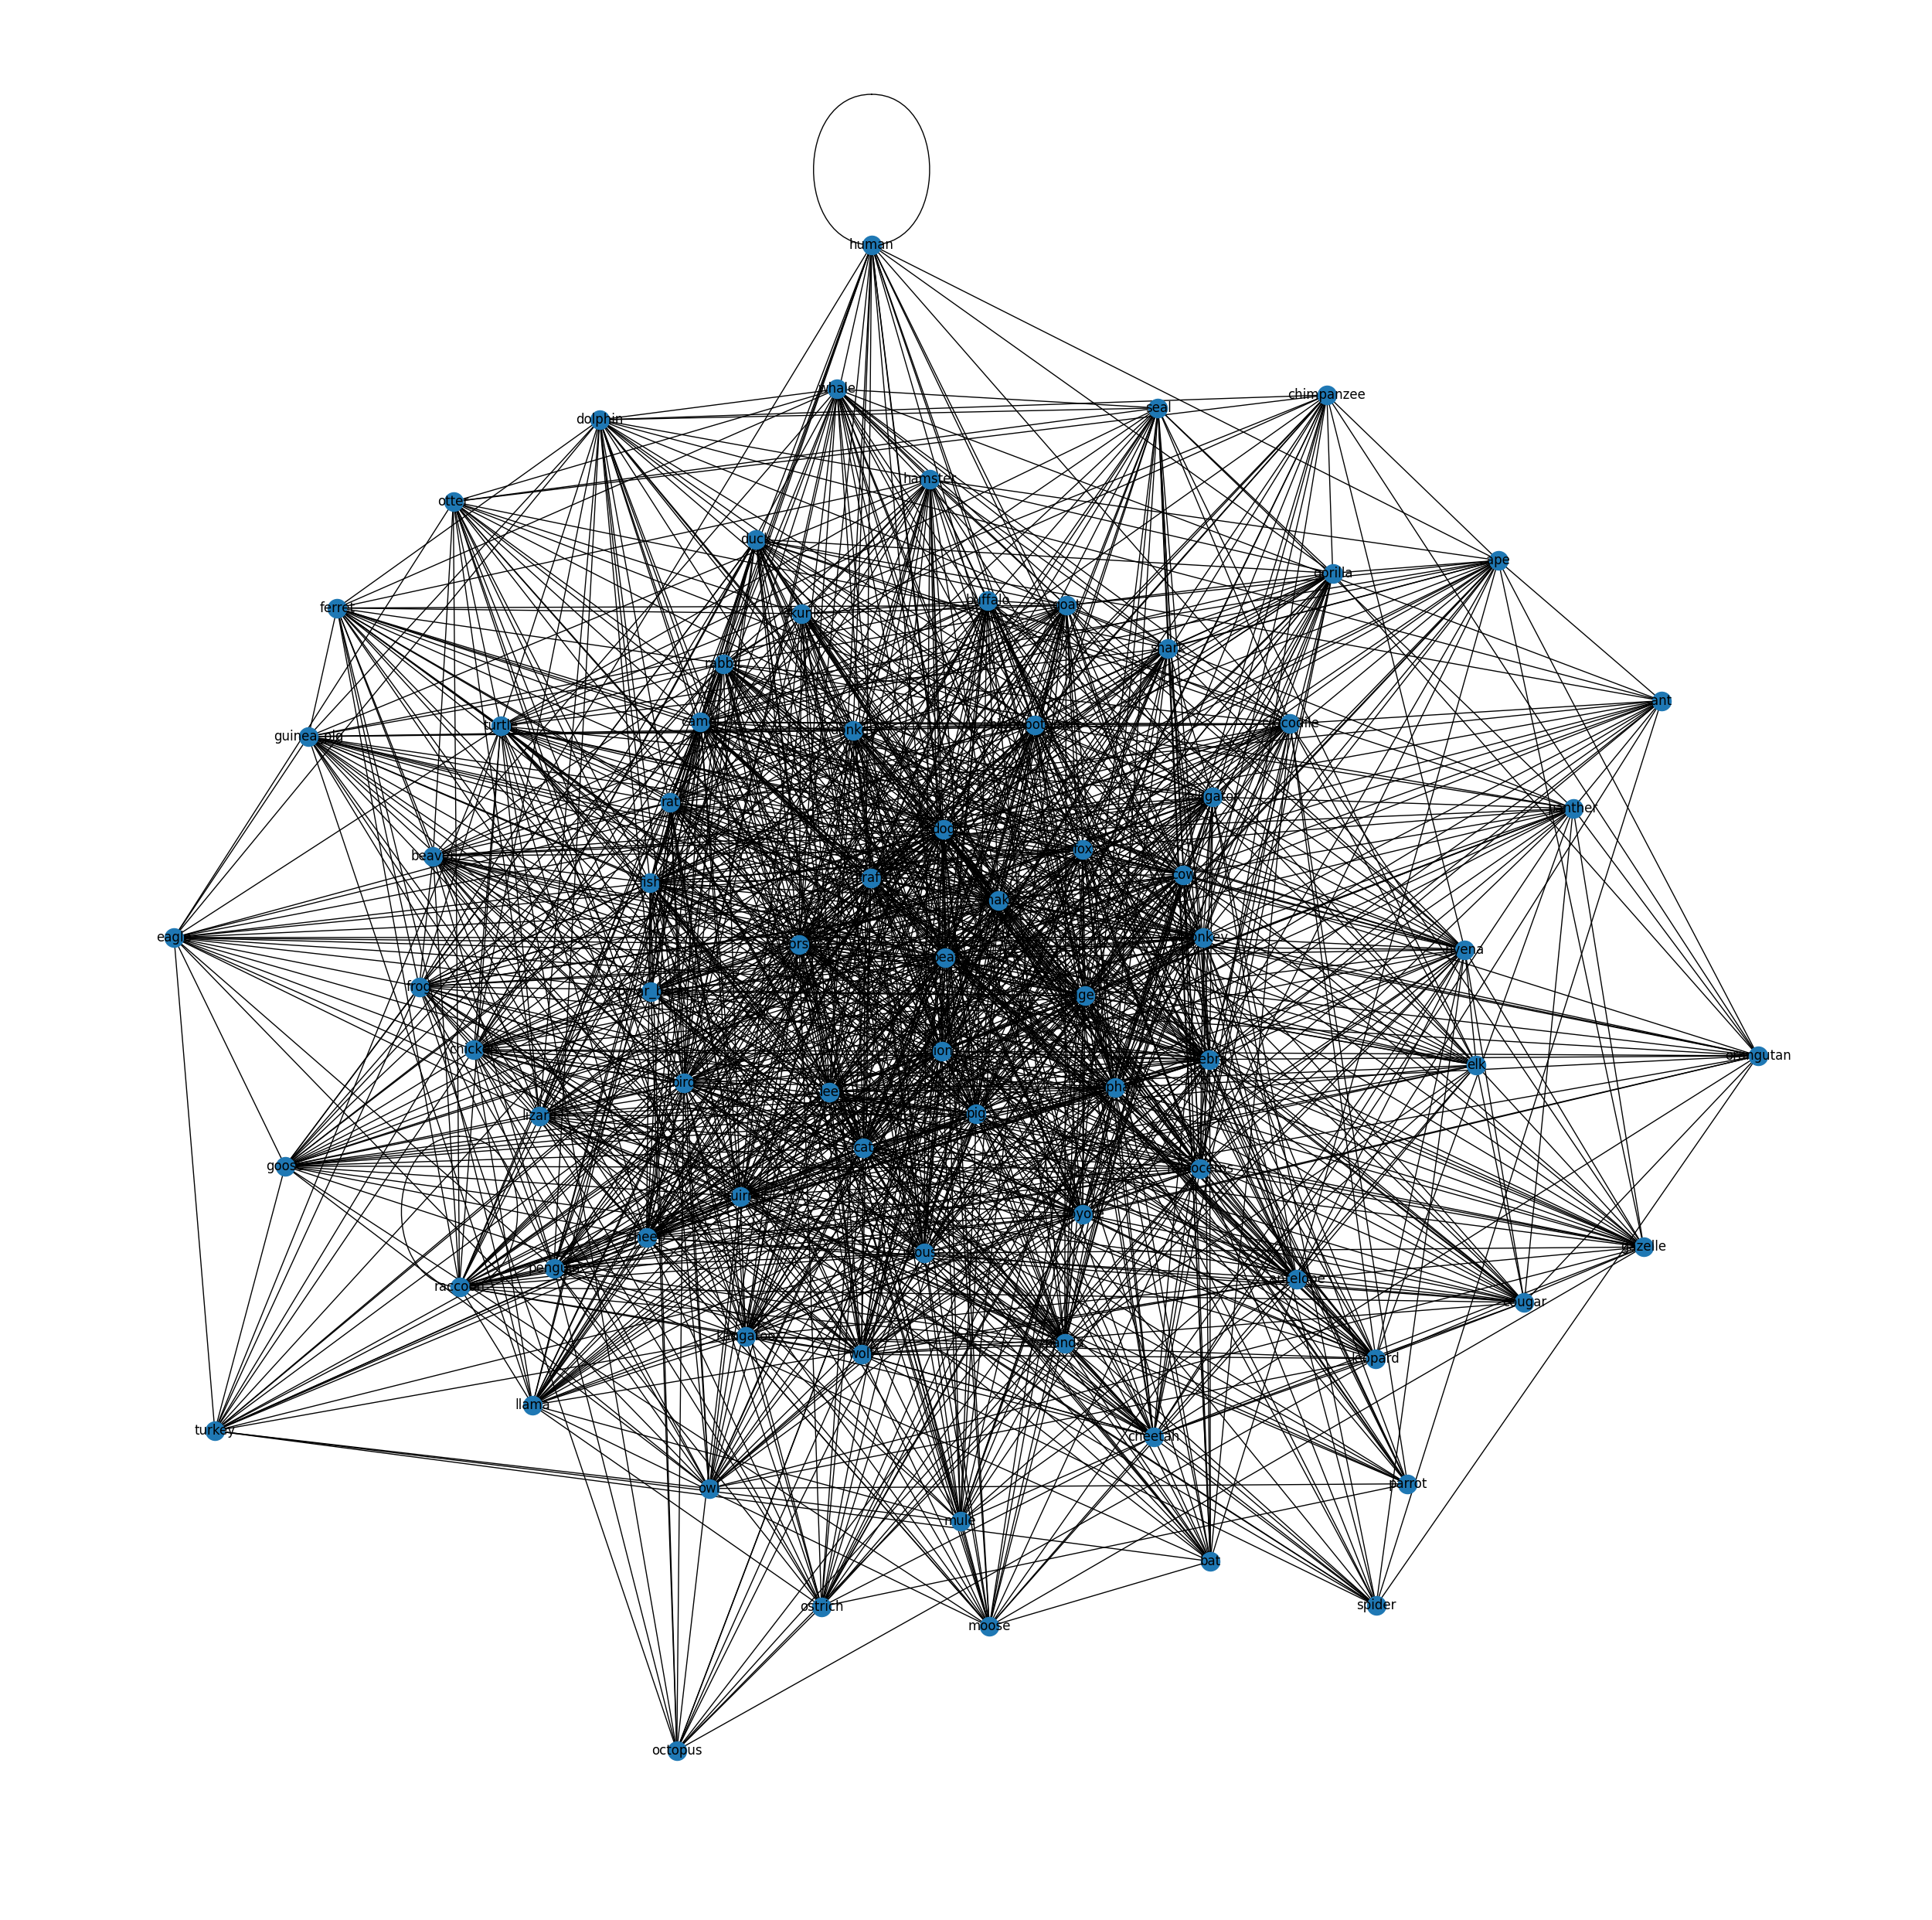

In [10]:
fig, ax = plt.subplots(figsize=(32,32))
nx.draw(animal_pairs, with_labels=True, ax=ax)

plt.show()

In [11]:
connected_list = [x for x in animal_pairs.nodes]

In [12]:
# try the small list, or, failing that, just the apes

In [13]:
smaller_animal_pair_data=animal_pair_data.loc[animal_pair_data['first_animal' ].isin( connected_list) & animal_pair_data['second_animal' ].isin( connected_list) ] 

In [14]:
joined_data=smaller_animal_pair_data.join(raw_dataset).drop(columns='[All_Ratings]')

In [15]:
big_matrix = pd.DataFrame(index=connected_list, columns = connected_list)

In [16]:
joined_data

first_animal second_animal  Average_Rating
Pair                                                         
alligator~antelope    alligator      antelope           1.940
alligator~bird        alligator          bird           2.080
alligator~buffalo     alligator       buffalo           1.080
alligator~elephant    alligator      elephant           1.140
alligator~fish        alligator          fish           1.000
...                         ...           ...             ...
zebra~seal                zebra          seal           1.040
zebra~shark               zebra         shark           1.067
zebra~snake               zebra         snake           1.880
zebra~tiger               zebra         tiger           2.720
zebra~turtle              zebra        turtle           1.120

[1601 rows x 3 columns]

In [17]:
#TODO wrap below section into functions

In [18]:
for row in joined_data.iterrows():
    big_matrix.loc[row[1].first_animal][row[1].second_animal] = row[1].Average_Rating
    big_matrix.loc[row[1].second_animal][row[1].first_animal] = row[1].Average_Rating

In [19]:
big_matrix = big_matrix.astype(float)

In [20]:
# big_matrix = big_matrix[big_matrix.isna().mean(1) < 0.5]
# big_matrix = big_matrix[big_matrix.index.to_list()]

In [21]:
big_matrix = big_matrix[big_matrix.isna().mean(1) < 0.33]

In [22]:
big_matrix = big_matrix[big_matrix.index.to_list()]

In [23]:
plt.matshow(big_matrix)

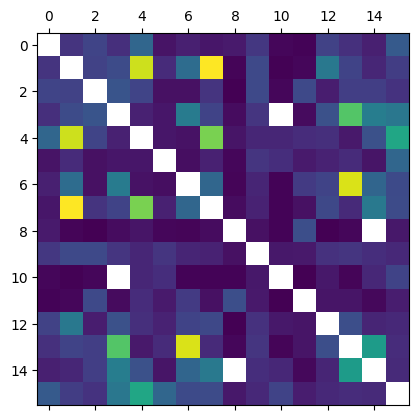

In [24]:
plt.show()

In [25]:
big_matrix.isna().mean(1)

pig         0.0625
lion        0.0625
bear        0.0625
deer        0.1250
cat         0.0625
monkey      0.0625
zebra       0.0625
tiger       0.0625
fish        0.1250
elephant    0.0625
bird        0.1250
snake       0.0625
giraffe     0.0625
horse       0.0625
cow         0.1250
dog         0.0625
dtype: float64

In [26]:
big_matrix.shape

(16, 16)

In [27]:
big_matrix

pig   lion   bear  deer    cat  monkey  zebra  tiger   fish  \
pig         NaN  1.780  2.080  1.70  2.717    1.28  1.460  1.320  1.370   
lion      1.780    NaN  2.020  2.20  5.820    1.64  2.840  6.220  1.067   
bear      2.080  2.020    NaN  2.36  2.080    1.24  1.240  1.780  1.000   
deer      1.700  2.200  2.360   NaN  1.480    1.32  3.180  2.040  1.180   
cat       2.717  5.820  2.080  1.48    NaN    1.32  1.260  5.160  1.300   
monkey    1.280  1.640  1.240  1.32  1.320     NaN  1.200  1.480  1.100   
zebra     1.460  2.840  1.240  3.18  1.260    1.20    NaN  2.720  1.080   
tiger     1.320  6.220  1.780  2.04  5.160    1.48  2.720    NaN  1.180   
fish      1.370  1.067  1.000  1.18  1.300    1.10  1.080  1.180    NaN   
elephant  1.840  2.160  2.160  1.80  1.560    1.81  1.550  1.500  1.240   
bird      1.100  1.040  1.100   NaN  1.560    1.68  1.060  1.060  1.060   
snake     1.060  1.100  2.160  1.16  1.660    1.38  1.880  1.240  2.260   
giraffe   2.020  3.100  1.425  2.30  1.700    1.50  2.040  2.125  1.020   
horse     1.720  2.040  1.960  4.82  1.360    1.64  5.917  1.620  1.100   
cow       1.460  1.560  1.960  3.22  2.300    1.29  2.700  3.117    NaN   
dog       2.480  1.940  1.760  3.06  4.080    2.72  2.175  2.200  1.340   

          elephant  bird  snake  giraffe  horse    cow    dog  
pig          1.840  1.10   1.06    2.020  1.720  1.460  2.480  
lion         2.160  1.04   1.10    3.100  2.040  1.560  1.940  
bear         2.160  1.10   2.16    1.425  1.960  1.960  1.760  
deer         1.800   NaN   1.16    2.300  4.820  3.220  3.060  
cat          1.560  1.56   1.66    1.700  1.360  2.300  4.080  
monkey       1.810  1.68   1.38    1.500  1.640  1.290  2.720  
zebra        1.550  1.06   1.88    2.040  5.917  2.700  2.175  
tiger        1.500  1.06   1.24    2.125  1.620  3.117  2.200  
fish         1.240  1.06   2.26    1.020  1.100    NaN  1.340  
elephant       NaN  1.34   1.36    1.740  1.800  1.683  1.600  
bird         1.340   NaN   1.00    1.340  1.080  1.580  2.050  
snake        1.360  1.00    NaN    1.300  1.300  1.110  1.420  
giraffe      1.740  1.34   1.30      NaN  2.250  1.540  1.600  
horse        1.800  1.08   1.30    2.250    NaN  3.860  1.660  
cow          1.683  1.58   1.11    1.540  3.860    NaN  1.620  
dog          1.600  2.05   1.42    1.600  1.660  1.620    NaN

In [28]:
# todo make into function
similarities = big_matrix.to_numpy()
similarity_vec = np.tril(similarities, -1)
similarity_vec = similarity_vec[np.nonzero(similarity_vec)]

In [29]:
# FIll in NA's 

In [30]:
similarity_vec = np.nan_to_num(similarity_vec, nan=min(similarity_vec))

In [31]:
dissimilarity_vec = np.exp(-1*similarity_vec)

In [32]:
len(dissimilarity_vec) 
# :=Y  = n(n-1)/2
# 2Y = n^2 - n
# 0 = n^2 - n - 2Y

# 0 = (n - 1/2) ^2 - 1/4 - 2Y 
# 2Y + 1/4 = (n - 1/2)^2
# N = 1/2 + sqrt(2Y + 1/4)


120

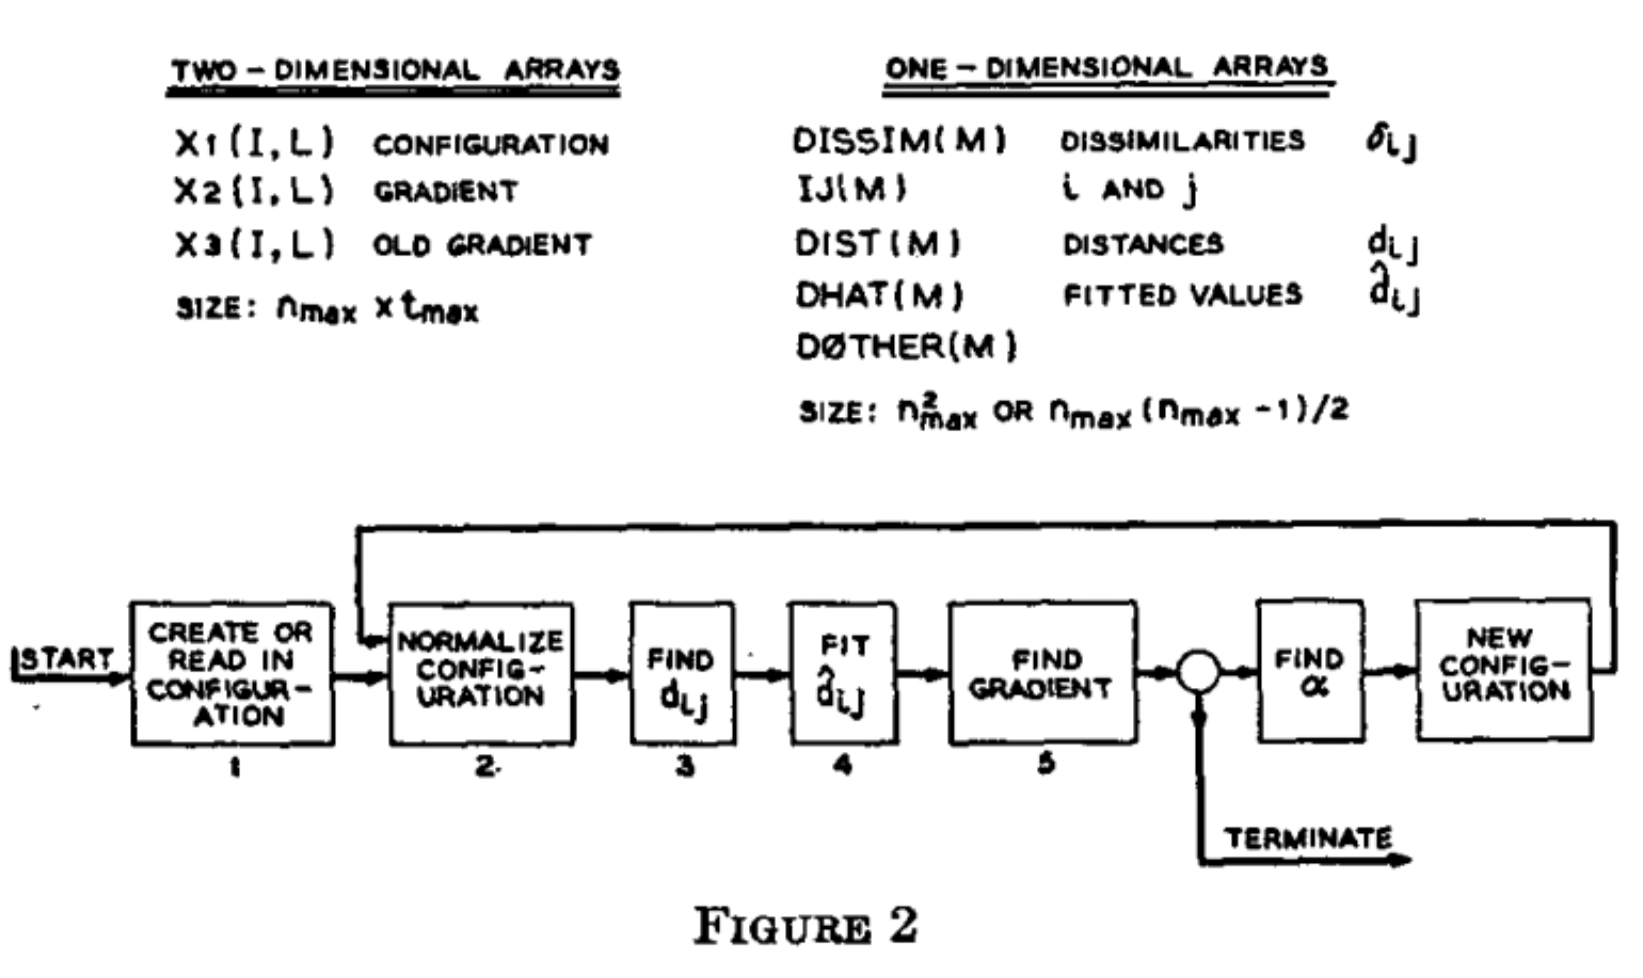
From Kruskal, 1964

Idea is to follow these steps, 

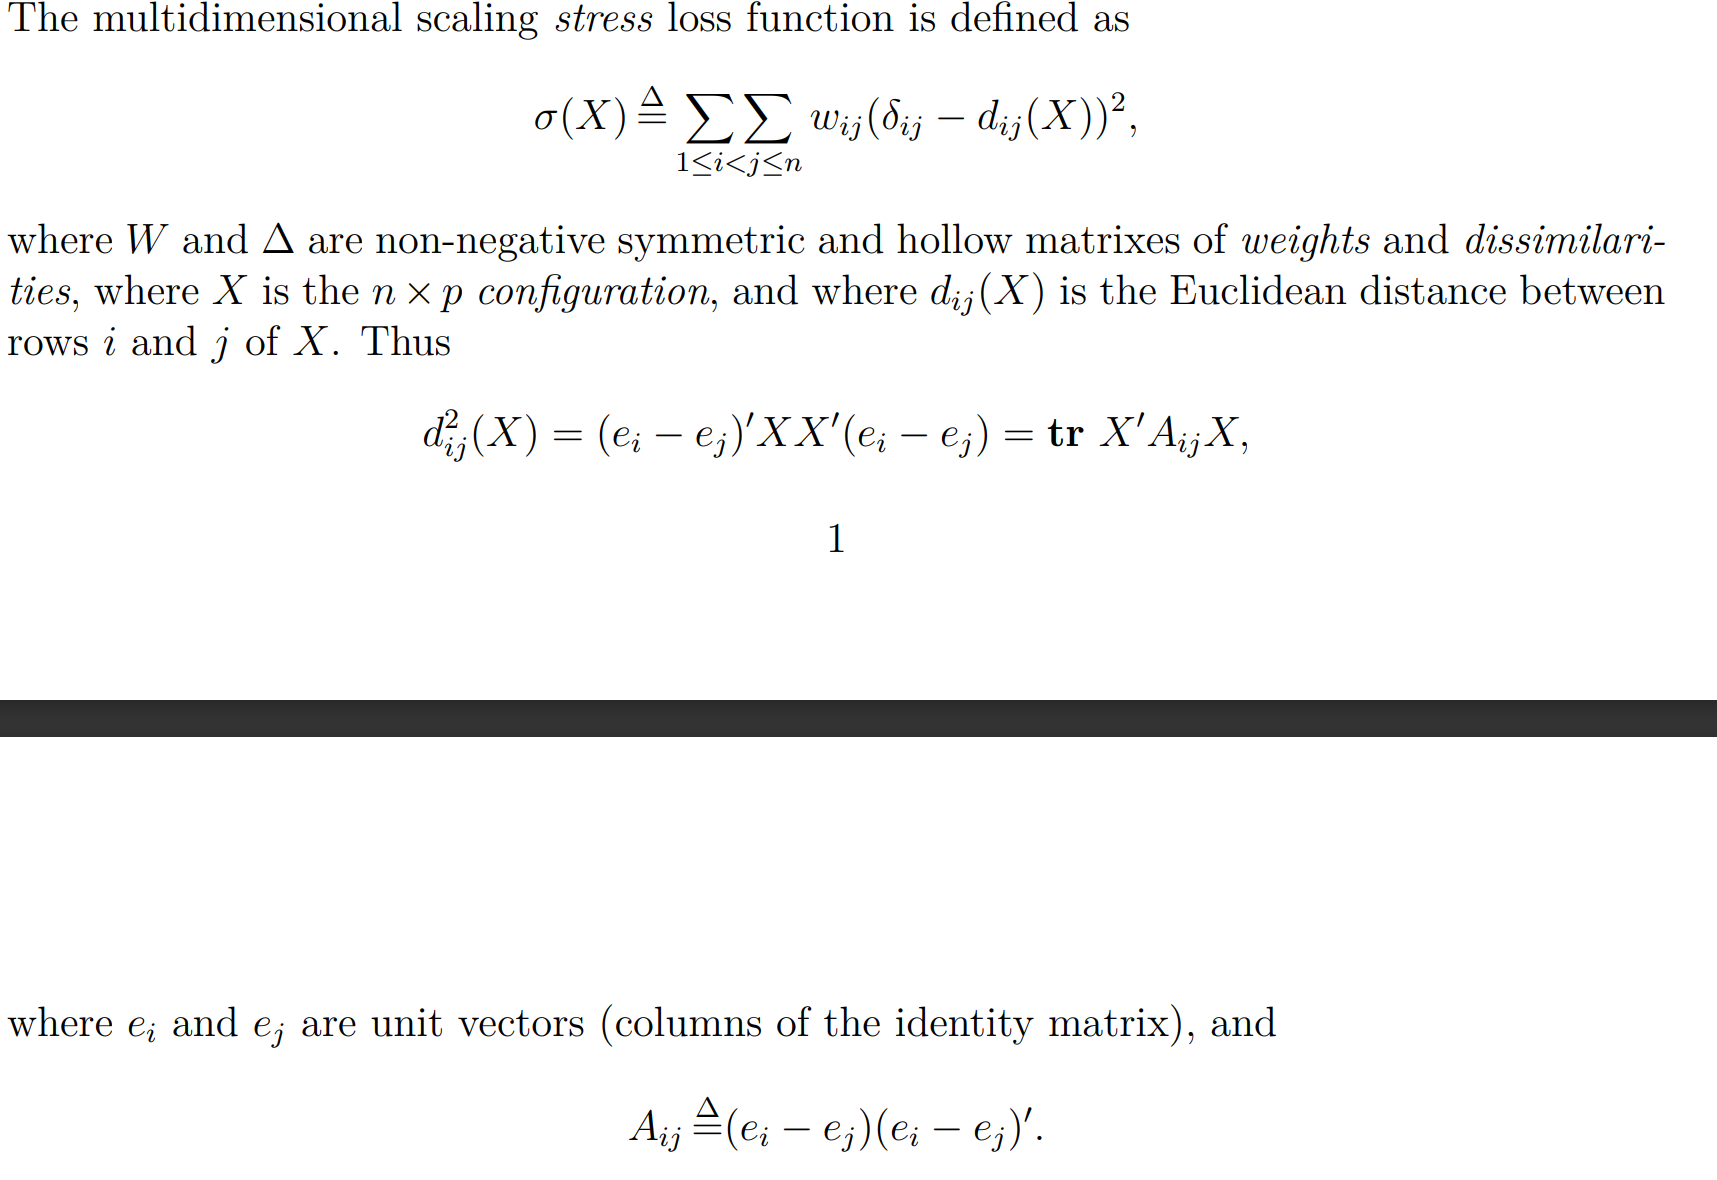
From https://jansweb.netlify.app/publication/deleeuw-e-18-c/
NB: $\delta_{ij}$ here is the true dissimilarity between $i$ and $j$ 

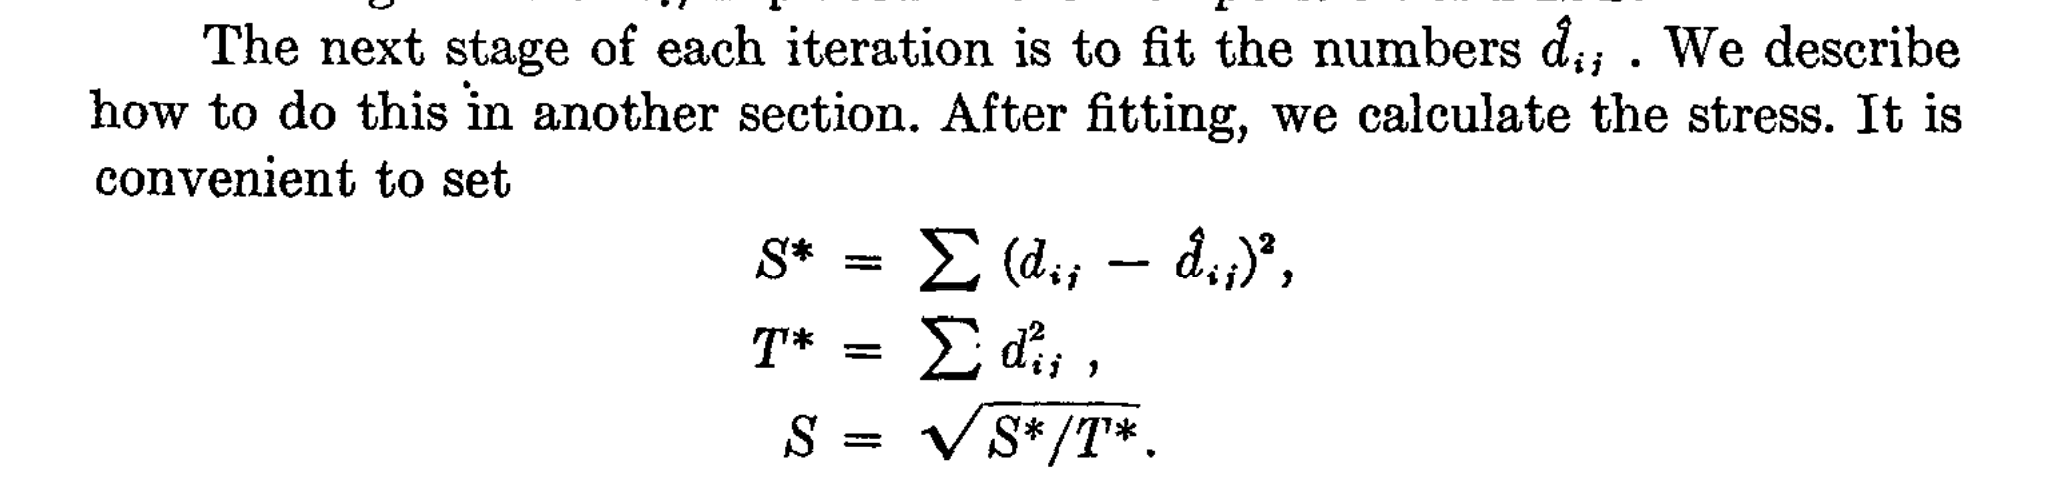
Stress Loss function from Kruskal, 1964

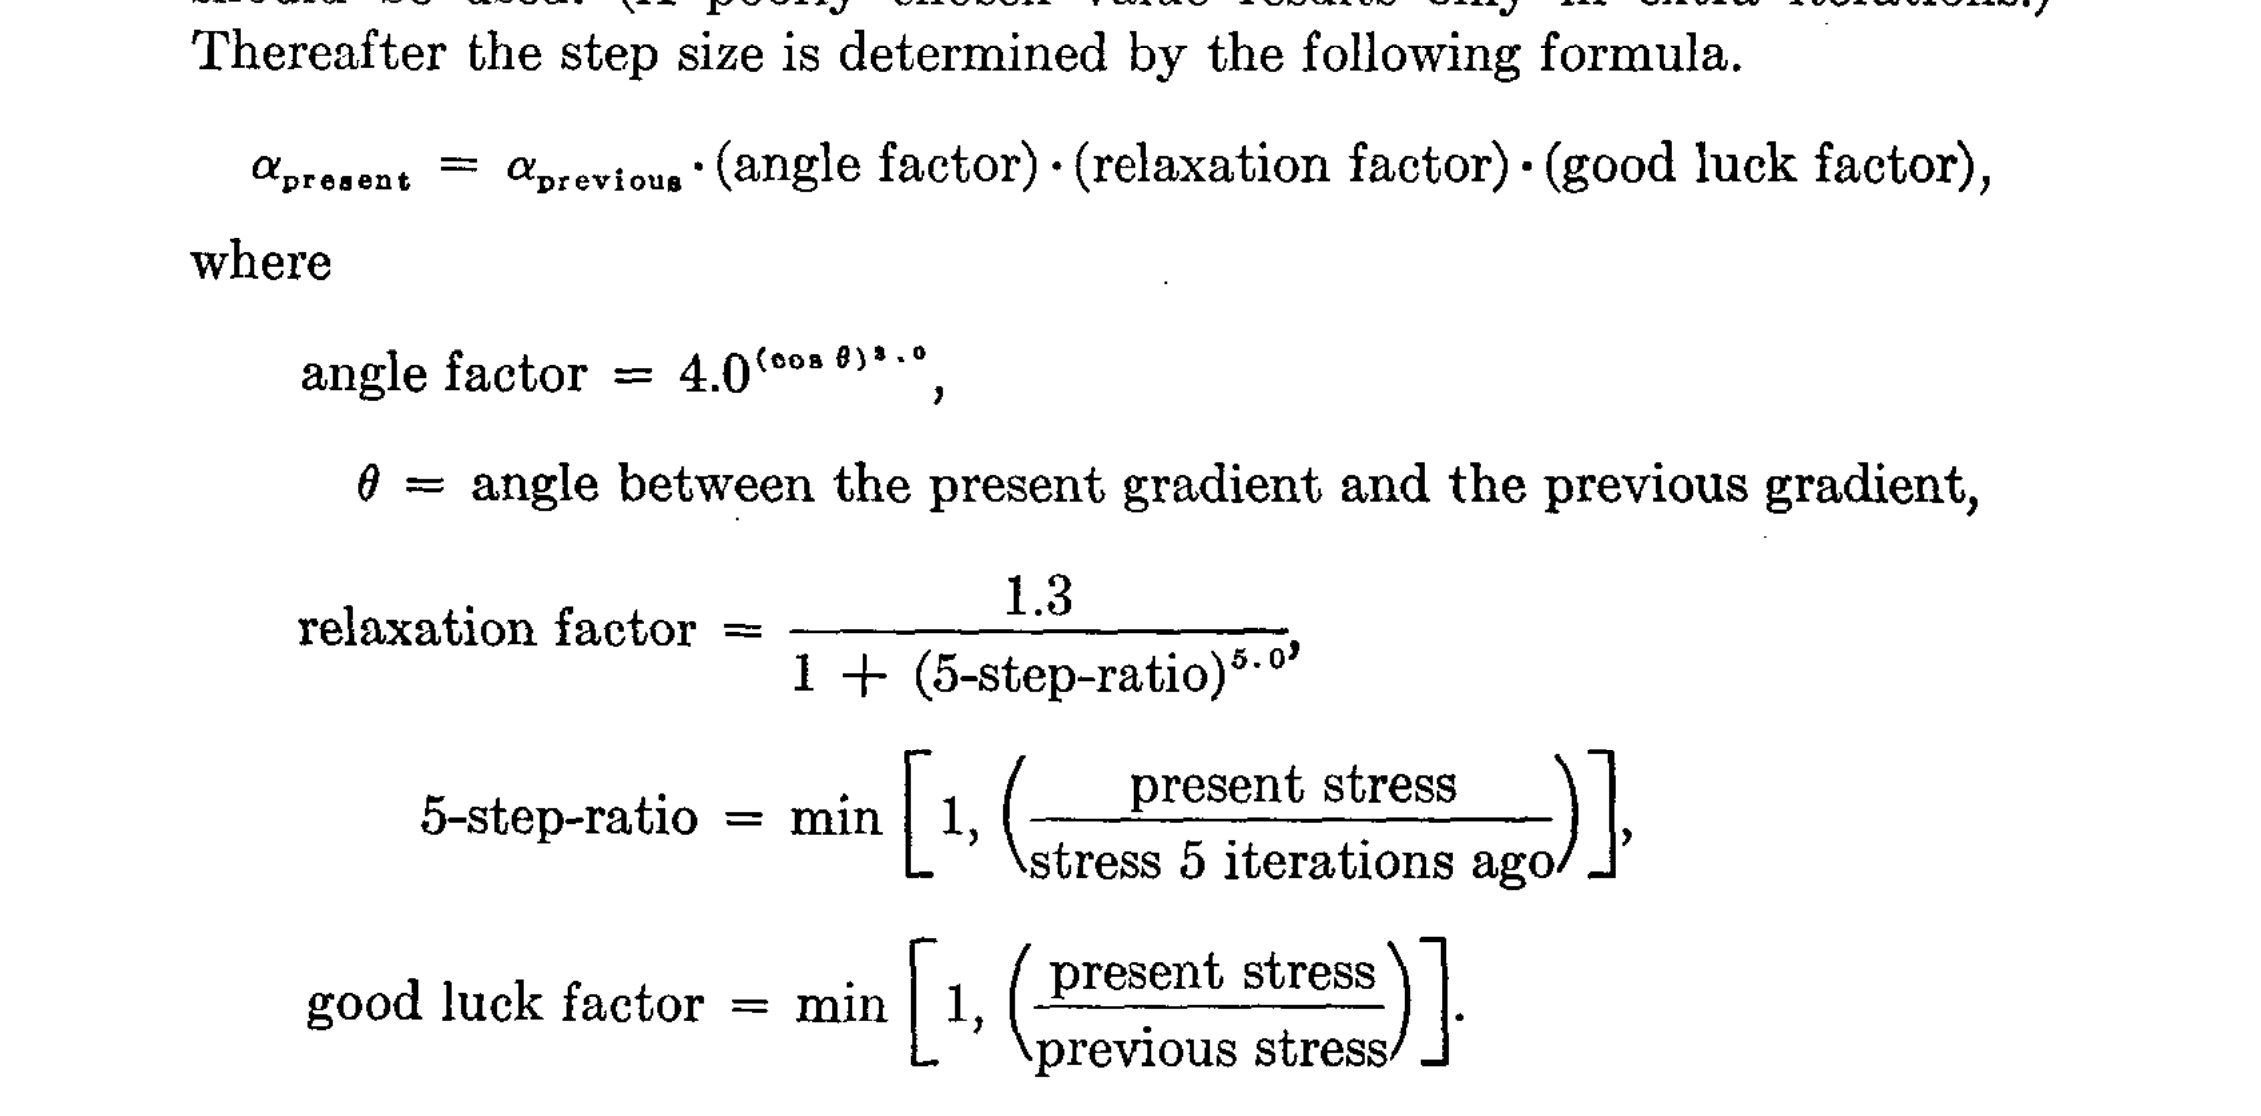
Optimizer from Kruskal, 1964

In [33]:
## Steps 
### Define configuration 
#### for each training iteration
#### normalize 
#### find pairwise distances
#### monotone regression
#### gradient descent



In [57]:
start_config = generate_starting_configuration(dissimilarity_vec, len(big_matrix.index))
start_tf_config = tf.convert_to_tensor(start_config)
# start_tf_config = tf.keras.utils.normalize(start_tf_config, axis=0)
# start_tf_config = tf.keras.utils.normalize(start_tf_config, axis=1)
start_tf_config=start_config
configuration = start_config

In [58]:
disty = PDistLayer()


In [60]:
with tf.GradientTape() as tape:
    pdists = get_pairwise_distances(configuration)
gradient = tape.gradient(pdists, configuration)

AttributeError: 'numpy.ndarray' object has no attribute '_id'

In [37]:
# The monotone regression: wrap in function
configuration = deepcopy(start_config)
model = MDSModel(configuration)
model.compile(optimizer='adam', loss=stress)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss_object = stress

In [38]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [39]:
@tf.function
def train_step(config, dis_vec):
    with tf.GradientTape(persistent=False) as tape:
#         tape.watch(config)
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(config, training=True)
        print("made predictions")
        loss = loss_object(dis_vec, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    return predictions 

In [40]:
# train_step(start_tf_config, dissimilarity_vec)

In [41]:
model.trainable_variables


[<tf.Variable 'initial_config:0' shape=(16, 2) dtype=float64, numpy=
 array([[1., 0.],
        [0., 1.],
        [2., 0.],
        [0., 2.],
        [3., 0.],
        [0., 3.],
        [4., 0.],
        [0., 4.],
        [5., 0.],
        [0., 5.],
        [6., 0.],
        [0., 6.],
        [7., 0.],
        [0., 7.],
        [8., 0.],
        [0., 8.]])>,
 <tf.Variable 'derived_config:0' shape=(16, 2) dtype=float64, numpy=
 array([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])>]

In [42]:
#looks like gradient loss is messed up by the distance step! What to do next 

In [43]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
min_loss = 1e6
train_loss.reset_states()

preds = train_step(configuration, dissimilarity_vec)
diff = -10 
for epoch in range(50):
    while abs(diff) >= 1e-3:
# normalize! 
    #TODO: Convert to pure tf
        configuration/=np.linalg.norm(configuration)
    # pairwise dist 
    ### Two options here: 
    #### 1. (suboptimal) use the "canned" formulas for the gradient and just use TF for the monotone regression
    #### 2. write the first layer after the inputs to compute pairwise distances and then to vectorize the lower tri, followed by a couple dense layers 
        old_loss = train_loss.result()
    # Reset the metrics at the start of the next epoch
        train_loss.reset_states()

        preds = train_step(configuration, dissimilarity_vec)

        # Now, apply the gradient of the stress to update the configuration 


        print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}')
        diff = train_loss.result() - old_loss
        print(f'Diff: {diff}')



made predictions
[<tf.Tensor 'gradient_tape/mds_model/dense/MatMul/MatMul_1:0' shape=(120, 128) dtype=float32>, <tf.Tensor 'gradient_tape/mds_model/dense/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/mds_model/dense_1/MatMul/MatMul_1:0' shape=(128, 120) dtype=float32>, <tf.Tensor 'gradient_tape/mds_model/dense_1/BiasAdd/BiasAddGrad:0' shape=(120,) dtype=float32>, <tf.Tensor 'gradient_tape/mds_model/multiply/mul/mul/Mul_1:0' shape=(16, 2) dtype=float64>, <tf.Tensor 'gradient_tape/mds_model/multiply/mul/mul/Mul:0' shape=(16, 2) dtype=float64>]
made predictions
[<tf.Tensor 'gradient_tape/mds_model/dense/MatMul/MatMul_1:0' shape=(120, 128) dtype=float32>, <tf.Tensor 'gradient_tape/mds_model/dense/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/mds_model/dense_1/MatMul/MatMul_1:0' shape=(128, 120) dtype=float32>, <tf.Tensor 'gradient_tape/mds_model/dense_1/BiasAdd/BiasAddGrad:0' shape=(120,) dtype=float32>, <tf.Tensor 'gradient_t

In [44]:
model.summary()

Model: "mds_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 p_dist_layer_1 (PDistLayer)  multiple                 0         
                                                                 
 dense (Dense)               multiple                  15488     
                                                                 
 dense_1 (Dense)             multiple                  15480     
                                                                 
Total params: 31,032
Trainable params: 31,032
Non-trainable params: 0
_________________________________________________________________


In [45]:
preds

<tf.Tensor: shape=(1, 120), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

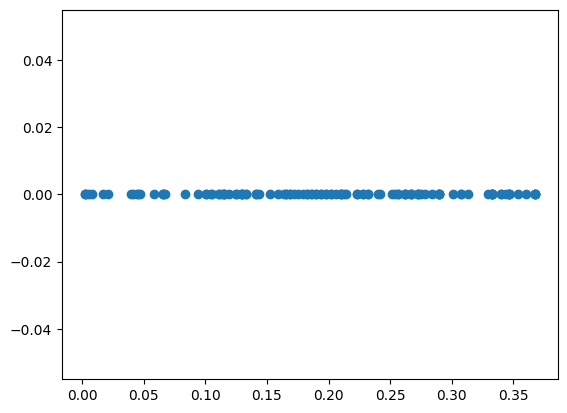

In [46]:
plt.scatter(dissimilarity_vec, preds)
plt.show()

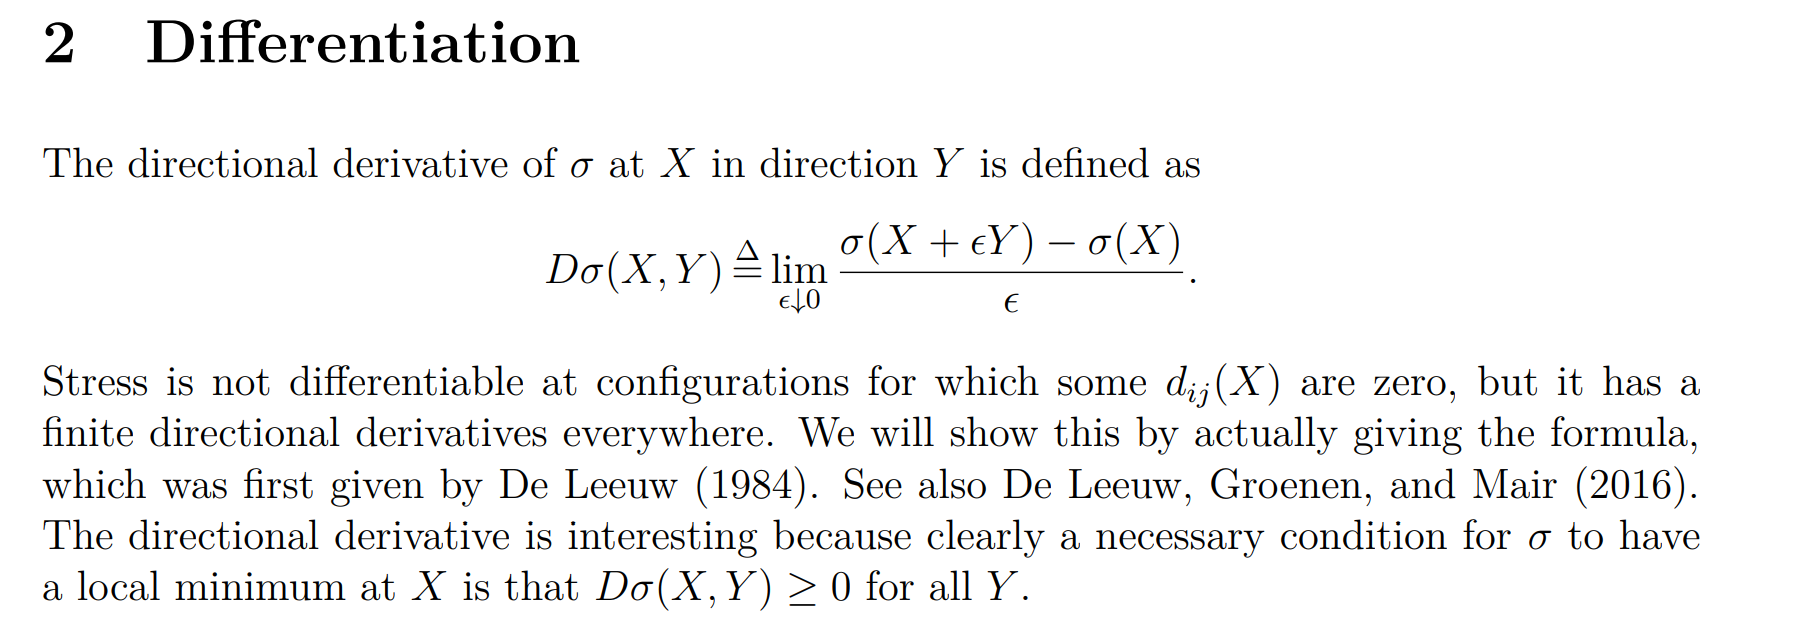
From https://jansweb.netlify.app/publication/deleeuw-e-18-c/

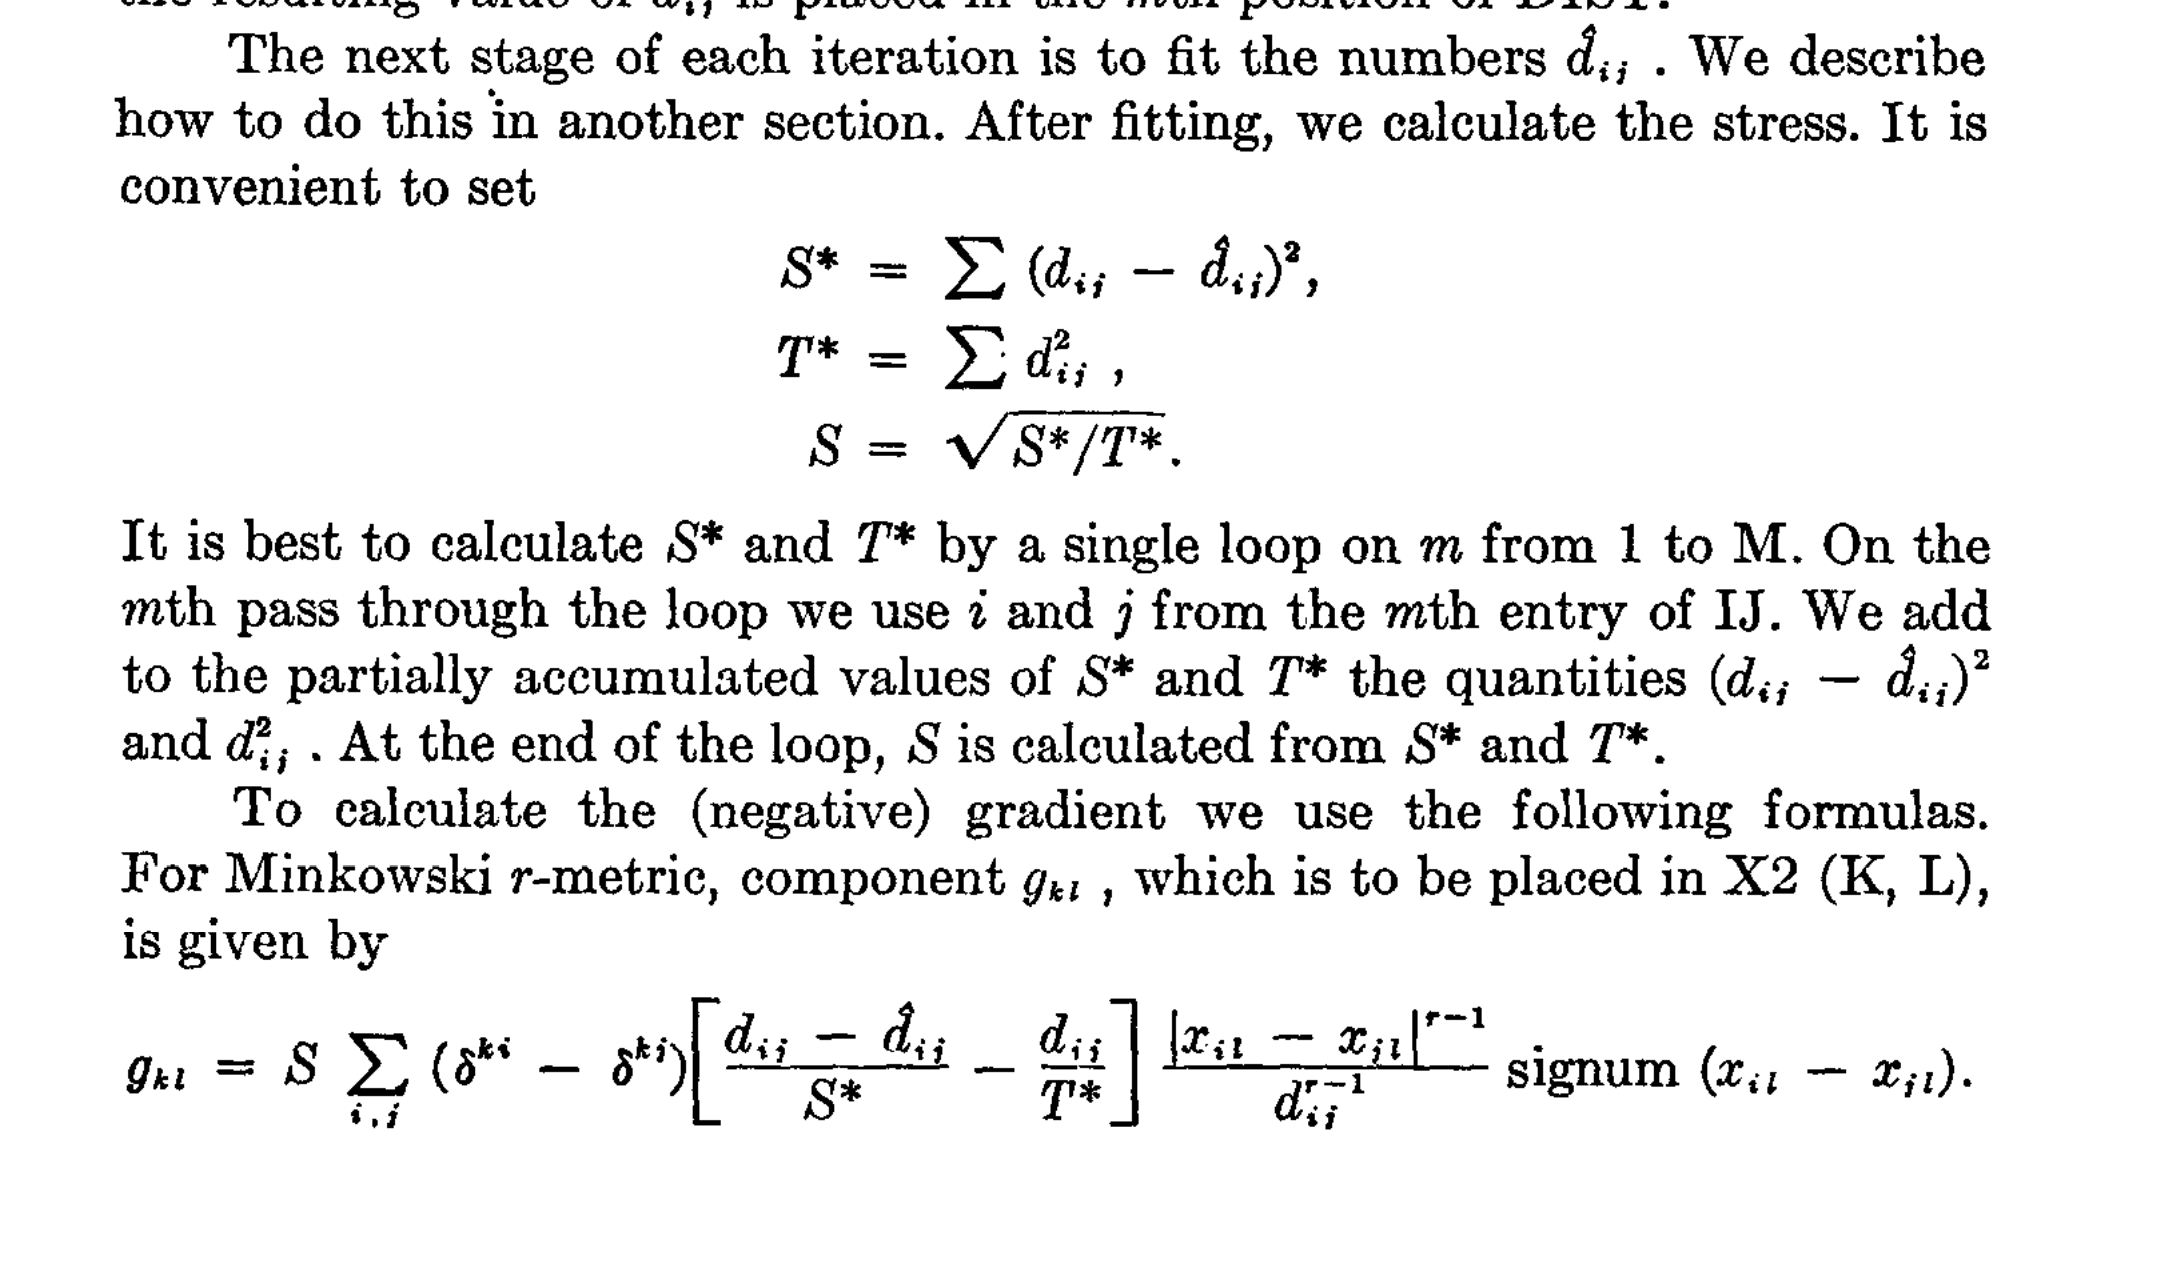
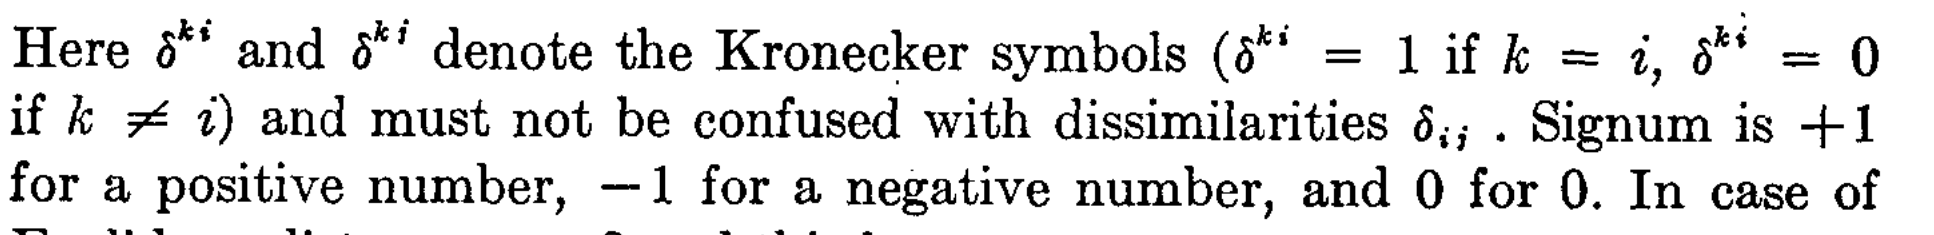
From Kruskal, 1964

In [47]:
model.trainable_variables

[<tf.Variable 'mds_model/dense/kernel:0' shape=(120, 128) dtype=float32, numpy=
 array([[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        ...,
        [-0.        , -0.        ,  0.00606437, ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        ,  0.03399517, -0.        , ..., -0.        ,
          0.08941874, -0.        ]], dtype=float32)>,
 <tf.Variable 'mds_model/dense/bias:0' shape=(128,) dtype=float32, numpy=
 array([-0.35605705, -0.3198188 , -0.14897834, -0.35340446, -0.36859795,
        -0.10731955, -0.25340796, -0.25296077, -0.36091158, -0.2539823 ,
        -0.36417326, -0.25343117, -0.37307608, -0.1160828

In [48]:
len(dissimilarity_vec)


120

In [49]:
latest_config =  model.trainable_variables[-1]
latest_config  = latest_config.numpy() + np.random.uniform(size = latest_config.shape, low = 0., high = 0.20)


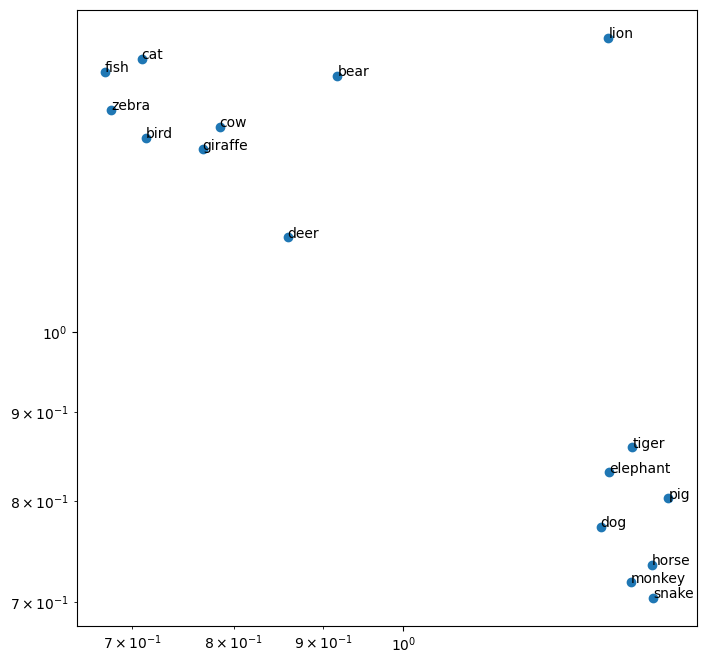

In [50]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x=latest_config[:,0], y=latest_config[:,1])
for i, label in enumerate(big_matrix.index.to_list()):
       plt.annotate(label, (latest_config[i,0], latest_config[i,1]))

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [51]:
latest_config

array([[1.41700058, 0.80276114],
       [1.30950379, 1.47530091],
       [0.91708   , 1.40248277],
       [0.85888216, 1.13330137],
       [0.70884204, 1.43426006],
       [1.34921164, 0.71819776],
       [0.68089253, 1.34138389],
       [1.35128029, 0.85843445],
       [0.67531006, 1.4098557 ],
       [1.3102414 , 0.83080711],
       [0.71298647, 1.29250655],
       [1.3883174 , 0.70391522],
       [0.76820683, 1.27272722],
       [1.38635318, 0.73523222],
       [0.78554178, 1.31164543],
       [1.29620284, 0.77288783]])

In [52]:
plt.matshow(model.get_layer('dense').weights[0])

In [53]:
np.min(model.get_layer('dense').weights[0])

-0.0